# Applied Data Science @ Columbia

## Project 1: What made you happy today?


### Project Description
- Project title: Childfree Life - What Brings Happiness to Married Couples Without Children in America?
- Author: Tien Nguyen - tn2510
- Project Summary: 
In contemporary America, the choice to lead a childfree life is increasingly prevalent. This project delves into the intricacies of happiness among married couples who have consciously opted out of parenthood. Through comprehensive research and interviews, several key inquiries were addressed to illuminate the facets of their contentment and fulfillment.

+ Key Questions Explored:

**1. What made married people without children happy?**

**2. Do childless married couples ever desire to have children? Do they regret not having a child?**

**3. Within a family without children, how can husbands make their wives happy?**

(Please see the HappyDB_Data_Analysis_Tien_Nguyen(no_code) file or the PDF file for the data story/analysis)

### Import Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as p
import warnings 
warnings.filterwarnings('ignore')

import re
import random
from collections import Counter

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from gensim.parsing.preprocessing import remove_stopwords, strip_numeric, strip_punctuation, strip_short

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy

[nltk_data] Downloading package punkt to /Users/stephanie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Datasets

In [2]:
cleaned_hm = pd.read_csv("/Users/stephanie/ADS/data/cleaned_hm.csv")
# Show the first 5 rows of this dataframe
cleaned_hm.head() 

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [4]:
demographic = pd.read_csv("/Users/stephanie/ADS/data/demographic.csv")
# Show the first 5 rows of the dataframe
demographic.head() 

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


### Data Cleaning and Preprocessing

**1. Clean the Demographic Dataframe**

In [5]:
# Ages are represented inconsistently, with some being integers and others including decimals. 
# To ensure uniformity, convert the age to float --> integer & remove any decimals. 
def convert_age_to_integer(age):
    try:
        age = int(float(age))
    except ValueError:
        # If conversion fails, return None
        return None
    return age

demographic['age'] = demographic['age'].apply(convert_age_to_integer)

# Remove rows with None in Age column
demographic = demographic.dropna(subset=['age'])

In [6]:
# Filter the Demographic DataFrame to keep only rows with 
#'marital' as 'married', 'country' as 'USA', and 'parenthood' as 'n'
demo1 = demographic[(demographic['marital'] == 'married') & (demographic['country'] == 'USA') & (demographic['parenthood'] == 'n')]

# Filter the Demographic DataFrame to keep only rows with 
#'marital' as 'married', 'country' as 'USA', and 'parenthood' as 'n'

demo2 = demographic[(demographic['marital'] == 'married') & (demographic['country'] == 'USA') & (demographic['parenthood'] == 'y')]

**2. Clean the Cleaned_hm Dataframe**

In [7]:
#Remove unnecessary columns in cleaned_hm
cleaned_hm = cleaned_hm.drop(columns=['original_hm', 'modified', 'num_sentence', 'ground_truth_category'])

In [8]:
# Merge Cleaned_hm and Demographic DataFrames
#Only married
df_cd1 = pd.merge(cleaned_hm, demo1, on ="wid")

#Only single
df_cd2 = pd.merge(cleaned_hm, demo2, on ="wid")


In [9]:
df_cd1.head(5)

,hmid,wid,reflection_period,cleaned_hm,predicted_category,age,country,gender,marital,parenthood
0,27699,156,24h,I napped with my husband on the bed this after...,affection,47.0,USA,f,married,n
1,27899,156,24h,My mother-in-law offered me money so I could b...,affection,47.0,USA,f,married,n
2,28099,156,24h,"I've been thinking about dreams, life and deat...",enjoy_the_moment,47.0,USA,f,married,n
3,37561,156,24h,"I've watched the movie ""Moana"" and it made me ...",enjoy_the_moment,47.0,USA,f,married,n
4,38560,156,24h,I found a new way to introduced my main male c...,achievement,47.0,USA,f,married,n


In [10]:
df_cd2.head(5)

,hmid,wid,reflection_period,cleaned_hm,predicted_category,age,country,gender,marital,parenthood
0,27675,1936,24h,I went to the gym this morning and did yoga.,exercise,30.0,USA,f,married,y
1,27875,1936,24h,My husband passed his DOT physical and I don't...,affection,30.0,USA,f,married,y
2,28075,1936,24h,I went to bible study tonight with special nee...,bonding,30.0,USA,f,married,y
3,29876,1936,24h,I lost 5 pounds which is awesome considering I...,achievement,30.0,USA,f,married,y
4,30875,1936,24h,My husband started working more after having h...,affection,30.0,USA,f,married,y


**3. View Data Distribution**

In [11]:
gender_distribution = df_cd1['gender'].value_counts()
print(gender_distribution)

gender
m    4458
f    3759
o      27
Name: count, dtype: int64


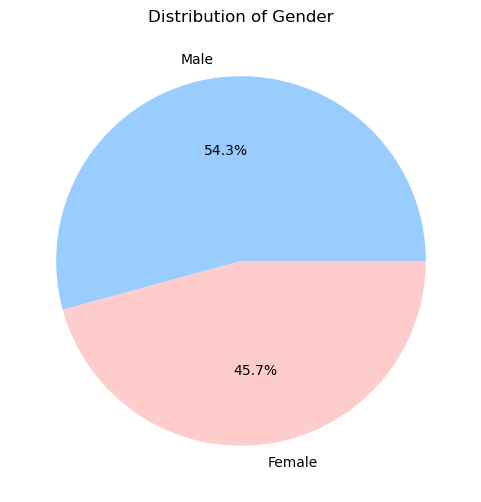

In [12]:
#Filter out entries with gender 'o'
df_cd1 = df_cd1[df_cd1['gender'] != 'o']

# Calculate the distribution of genders after filtering
gender_distribution = df_cd1['gender'].value_counts()

gender_labels = {'f': 'Female', 'm': 'Male'}

# Plotting the distribution as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index.map(gender_labels), autopct='%1.1f%%', colors=['#99ccff', '#ffcccc'])

# Adding a title
plt.title('Distribution of Gender')

# Displaying the plot
plt.show()

The dataset exhibits a relatively balanced distribution between genders, with married men representing 54.3% and married women constituting 45.7%. This near-equal split suggests a fairly even representation of married individuals across genders within the dataset.

## 1. What made married people without children happy?

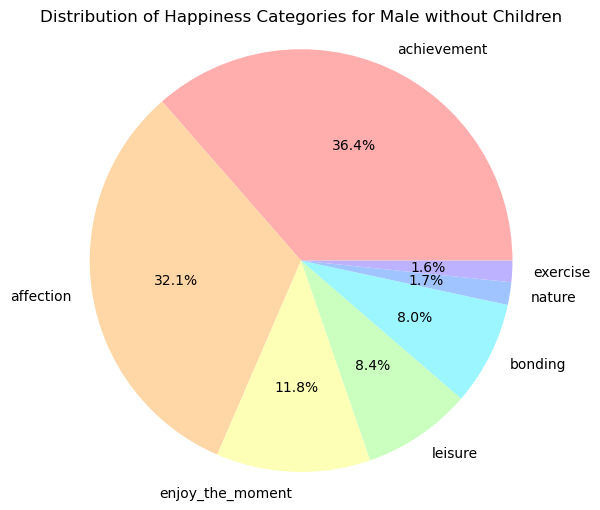

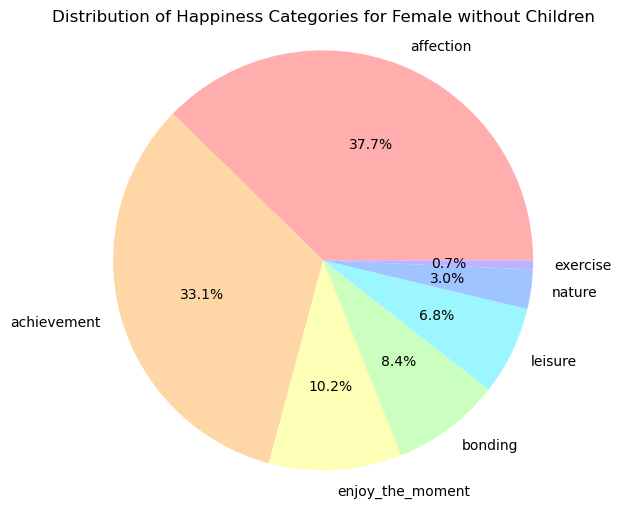

In [13]:
# Filter dataframe for male and female separately
male_df = df_cd1[df_cd1['gender'] == 'm']
female_df = df_cd1[df_cd1['gender'] == 'f']

# Calculate the distribution of happiness categories for male and female
male_category_distribution = male_df['predicted_category'].value_counts()
female_category_distribution = female_df['predicted_category'].value_counts()

# Define custom colors for the slices
colors = ['#ffadad', '#ffd6A5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#bdb2ff']

# Plotting the distribution for male as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(male_category_distribution, labels=male_category_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Happiness Categories for Male without Children')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Plotting the distribution for female as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(female_category_distribution, labels=female_category_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Happiness Categories for Female without Children')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Based on the charts, we observe minimal disparity among the categories, and the order of categories appears consistent between childfree men and women in terms of what contributes to their happiness (these are happiness categories). 

Affection and achievement are prominent in both charts. **However, among childfree married men, achievement appears to play a more significant role in contributing to their happiness, followed by affection. Conversely, for women, affection takes precedence over achievement in terms of its contribution to their overall happiness.** Specifically, affection constitutes 37.7% as opposed to men's 32.1%. For men, achievement is the most significant category at 36.4%, while for women, it is the second most significant at 33.1%.

The precedence of affection for women and achievement for men highlights a subtle gender difference in happiness drivers.

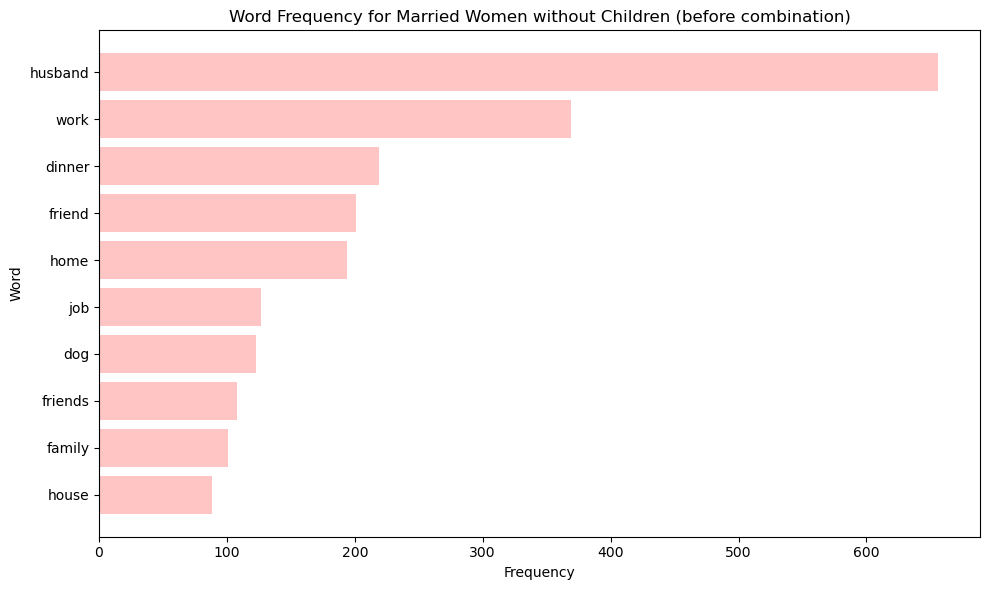

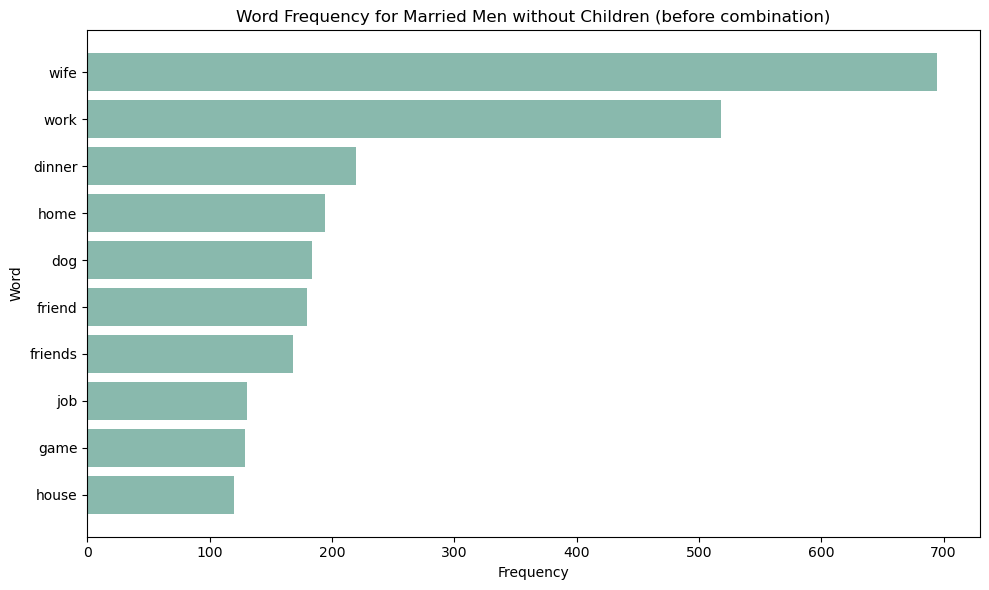

In [15]:
# Check Word Frequency before combining similar words
def plot_word_frequency1(text, title, num_words=10, color='#89B9AD'):
    # Preprocess text
    processed_text = strip_numeric(strip_punctuation(strip_short(remove_stopwords(text.lower()), minsize=3)))
    # Tokenize the text
    words = word_tokenize(processed_text)
    # Filter out custom stopwords
    words = [word for word in words if word not in all_stopwords]
    # Calculate word frequency
    fdist = FreqDist(words)
    # Select top N most frequent words
    top_words = fdist.most_common(num_words)
    # Extract words and frequencies
    words = [word for word, _ in top_words]
    frequencies = [freq for _, freq in top_words]
    
    # Create horizontal bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.gca().invert_yaxis()  # Invert y-axis to display most frequent word at the top
    plt.tight_layout()
    plt.show()

# Filter dataframe for female
female_text = ' '.join(df_cd1[df_cd1['gender'] == 'f']['cleaned_hm'])
# Plot word frequency for female with custom color
plot_word_frequency1(female_text, "Word Frequency for Married Women without Children (before combination)", color='#FFC5C5')

# Filter dataframe for male
male_text = ' '.join(df_cd1[df_cd1['gender'] == 'm']['cleaned_hm'])
# Plot word frequency for male with custom color
plot_word_frequency1(male_text, "Word Frequency for Married Men without Children (before combination)", color='#89B9AD')

First look at the top 10 repeated words for couples without children, we can see that both parties **emphasize relationships**, be it with a spouse, friends, or family, as well as personal interests and activities like enjoying meals and spending time at home. The presence of words related to work in both charts suggests that professional fulfillment is also a source of happiness for childless married individuals.

In the chart for **married men without children**, the most frequent word is **"wife,"** suggesting that the spouse is a central element of their happiness. "Work" also has a high frequency, indicating that their career or job is a significant part of their life. Other words like "dinner," "home," and "dog" suggest that simple pleasures, domestic life, and pets also play a role in their sense of contentment.

The chart for **married women without children** shows **"husband"** as the most frequent word, mirroring the men's chart where the spouse is also of high importance. "Work" is similarly significant, emphasizing career as a substantial factor in their happiness. "Dinner" and "friend" are also common words, pointing to social interactions and meals as sources of enjoyment. Additionally, "family" appears in their chart, which could indicate that connections with extended family are also valued.

**However**, in these two charts, we can see that there are terms with overlapping meanings. Hence, words like "job" and "work," "friend" and "friends" have been consolidated to more accurately reflect the frequency of these concepts.

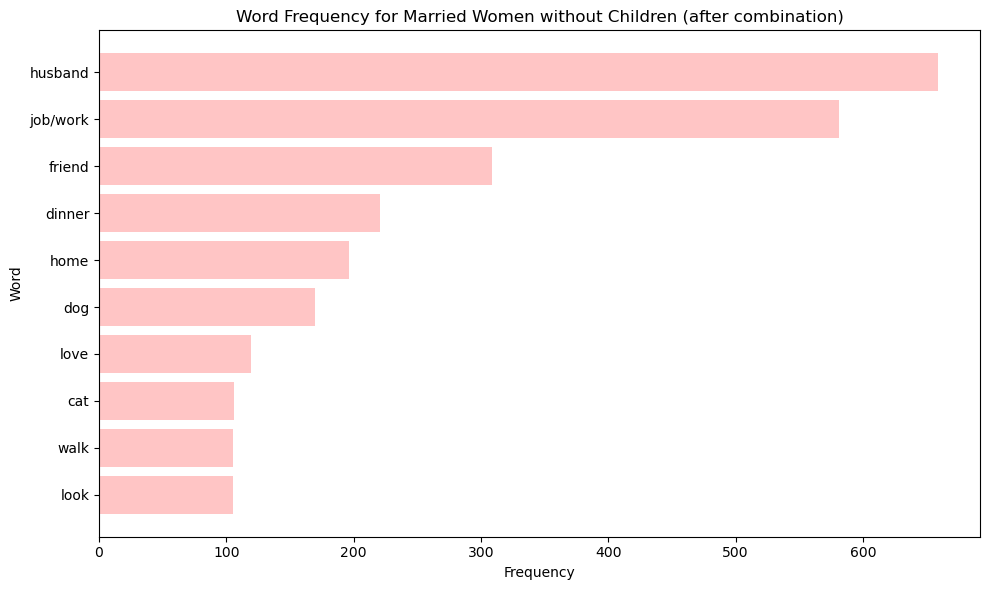

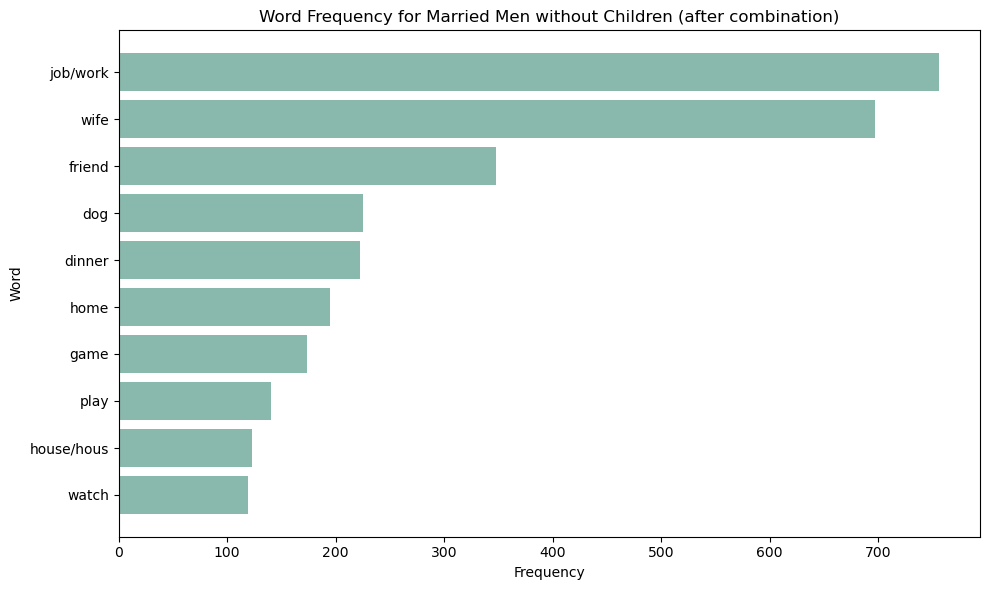

In [16]:
# Check Word Frequency after combining similar words
def plot_word_frequency2(text, title, num_words=10, color='#89B9AD'):
    # Preprocess text
    processed_text = strip_numeric(strip_punctuation(strip_short(remove_stopwords(text.lower()), minsize=3)))
    # Tokenize the text
    words = word_tokenize(processed_text)
    # Filter out custom stopwords
    words = [word for word in words if word not in all_stopwords]
    # Stem words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Calculate word frequency
    fdist = FreqDist(words)
    # Combine similar words
    combined_freq = {}
    for word, freq in fdist.items():
        if word in ['job', 'work']:
            combined_word = 'job/work'
        elif word in ['house', 'hous']:
            combined_word = 'house/hous'
        else:
            combined_word = word
        combined_freq[combined_word] = combined_freq.get(combined_word, 0) + freq
    # Select top N most frequent words
    top_words = sorted(combined_freq.items(), key=lambda x: x[1], reverse=True)[:num_words]
    # Extract words and frequencies
    words = [word for word, _ in top_words]
    frequencies = [freq for _, freq in top_words]
    
    # Create horizontal bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color = color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.gca().invert_yaxis()  # Invert y-axis to display most frequent word at the top
    plt.tight_layout()
    plt.show()

# Filter dataframe for female
female_text = ' '.join(df_cd1[df_cd1['gender'] == 'f']['cleaned_hm'])
# Plot word frequency for female with custom color
plot_word_frequency2(female_text, "Word Frequency for Married Women without Children (after combination)", color='#FFC5C5')

# Filter dataframe for male
male_text = ' '.join(df_cd1[df_cd1['gender'] == 'm']['cleaned_hm'])
# Plot word frequency for male with custom color
plot_word_frequency2(male_text, "Word Frequency for Married Men without Children (after combination)", color='#89B9AD')

The updated bar charts represent the word frequency for married men and women without children after combining similar terms, like "job" with "work" and "friend" with "friends." This consolidation provides a clearer picture of the priorities and interests within the responses of these groups.

For **married men without children**, we observe that "job/work" has become the most frequently mentioned term, surpassing "wife," which was the most frequent term before the combination. This shift highlights the central role that career and professional life play in the lives of these married men without children. It suggests that their identity or sense of fulfillment is strongly tied to their professional achievements or occupational roles.

In contrast, **for married women without children**, "husband" remains the most frequent term even after similar terms are combined, suggesting that the spousal relationship is still central to their discussions or thoughts related to happiness. "Job/work" also holds significant importance, indicating that career is an important aspect of their lives, but it doesn't surpass the emphasis on the spouse.

The interesting observation here is the difference in the placement of "wife" and "husband" between the two groups. While both men and women without children value their spouse and their jobs, the data suggests that married men without children may place a slightly greater emphasis on their professional life, while married women seem to place their relationship with their spouse at the top.

Other words that appear in the top frequencies, like "friend(s)," "dinner," "home," "dog," and "game" for men, and "friend(s)," "dinner," "home," "dog," "love," "cat," and "walk" for women, show that social relationships, domestic life, and pets are common sources of happiness for both genders. These terms paint a picture of people finding joy in their everyday experiences and relationships, with or without children.

## 2. Do childless married couples ever desire to have children? Do they regret not having a child?

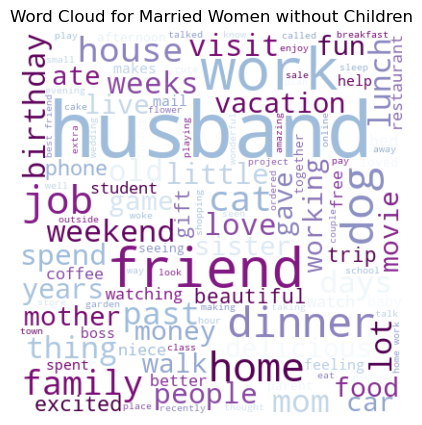

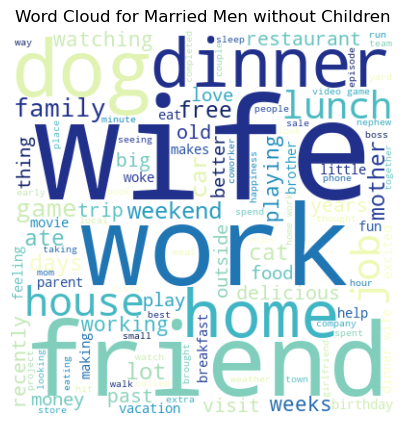

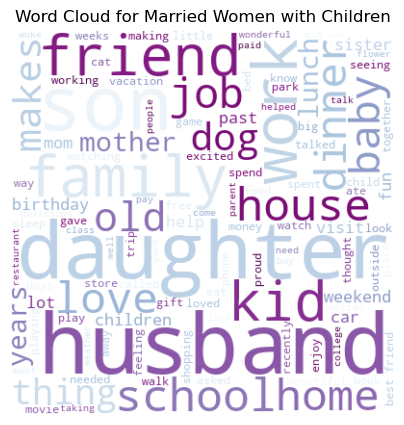

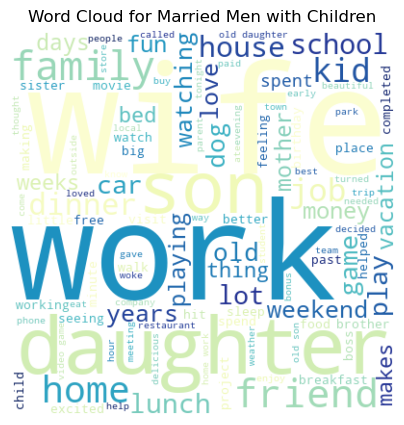

In [14]:
# Define custom stopwords
Based on the charts, we observe minimal disparity among the categories, and the order of categories appears consistent between childfree men and women in terms of what contributes to their happiness (these are happiness categories). 

Affection and achievement are prominent in both charts. **However, among childfree married men, achievement appears to play a more significant role in contributing to their happiness, followed by affection. Conversely, for women, affection takes precedence over achievement in terms of its contribution to their overall happiness.** Specifically, affection constitutes 37.7% as opposed to men's 32.1%. For men, achievement is the most significant category at 36.4%, while for women, it is the second most significant at 33.1%.

The precedence of affection for women and achievement for men highlights a subtle gender difference in happiness drivers.# Function to create word cloud
def create_word_cloud(text, title, colormap):
    # Preprocess text
    processed_text = strip_numeric(strip_punctuation(strip_short(remove_stopwords(text.lower()), minsize=3)))
    # Tokenize the text
    words = processed_text.split()
    # Filter out custom stopwords
    words = [word for word in words if word not in all_stopwords]
    # Join the words back into a single string
    filtered_text = ' '.join(words)
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=colormap, min_font_size=10).generate(filtered_text)
    # Plot the word cloud
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Filter dataframe for married women without children and create word cloud with BuPu colormap
female_text = ' '.join(df_cd1[df_cd1['gender'] == 'f']['cleaned_hm'])
create_word_cloud(female_text, "Word Cloud for Married Women without Children", 'BuPu')

# Filter dataframe for married men without children and create word cloud with YiGnBu_r colormap
male_text = ' '.join(df_cd1[df_cd1['gender'] == 'm']['cleaned_hm'])
create_word_cloud(male_text, "Word Cloud for Married Men without Children", 'YlGnBu_r')

# Filter dataframe for married women with children and create word cloud with BuPu colormap
female_text = ' '.join(df_cd2[df_cd2['gender'] == 'f']['cleaned_hm'])
create_word_cloud(female_text, "Word Cloud for Married Women with Children", 'BuPu')

# Filter dataframe for married men with children and create word cloud with YiGnBu_r colormap
male_text = ' '.join(df_cd2[df_cd2['gender'] == 'm']['cleaned_hm'])
create_word_cloud(male_text, "Word Cloud for Married Men with Children", 'YlGnBu_r')

From the word clouds:

- **Married Men with Children**: The focus seems to be on family-related terms like "son", "daughter", "family", "home", and activities such as "game", "watching", "vacation", indicating a life that revolves around family activities and responsibilities.

- **Married Women with Children**: Similar to the men's word cloud, we see a strong family orientation with words like "son", "daughter", "family", "school", and "home". There's also a mention of emotional terms such as "love", "proud", which may suggest fulfillment in their roles.

- **Married Men without Children**: The words "wife", "work", "free", "travel", "dog", "dinner", and "weekend" suggest a focus on personal freedom, hobbies, and leisure activities. The presence of "work" indicates that career may also play a significant role in their lives. The absence of words indicating a desire for children or regret over not having them may imply contentment with their current lifestyle.

- **Married Women without Children**: This word cloud also emphasizes personal freedom and leisure with words like "husband", "vacation", "weekend", and "dinner". "Work" is similarly prominent, suggesting that career is an important aspect of life. The focus on the partnership with the "husband" and on personal activities might indicate satisfaction with their life as it is.

In both word clouds for childless married individuals, the notable repetition of "work" suggests that their careers are a significant aspect of their lives. In addition, the absence of words traditionally associated with a desire for children or regret, such as "wish", "regret", "children", "baby", or "parenting", could suggest that **these individuals may be focusing their energies on their professional achievements and finding fulfillment in their work and personal freedoms.**

## 3. Within a family without children, how can husbands make their wives happy?

<Figure size 1500x1500 with 0 Axes>

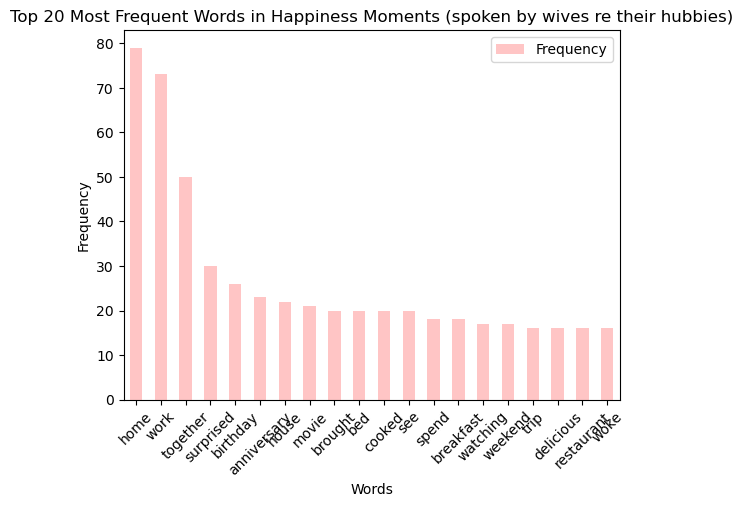

In [17]:
# Define custom stopwords
custom_stopwords = ['happy', 'one', 'really', 'much', 'us', 'first', 'last', 'week', 'felt', 'month', 'ago', 'months', 'like', 'took', 'year', 'yesterday', 'got', 'bit', 'good', 'day', 'time', 'watched', 'feel', 'enjoyed', 'able', 'found', 'played', 'finally', 'moment', 'night', 'said', 'saw',
                    'life', 'made', 'came', 'wanted', 'went', 'nice', 'bought', 'event', 'going', 'favorite', 'morning', 'told', 'great', 'make', 'today', 'new', 'getting', 'received', 'long', 'started', 'finished', 'hours', 'husband']
all_stopwords = set(stopwords.words('english') + custom_stopwords)


# Filter the dataframe to include only rows where the cleaned_hm column contains the word "husband"
female_spoken_df = df_cd1[df_cd1['gender'] == 'f']

# Filter the dataframe to include only rows where the cleaned_hm column contains the word "husband"
wife_df = female_spoken_df[female_spoken_df['cleaned_hm'].str.contains('husband', case=False)]

# Concatenate all the filtered happiness moments into a single string
wife_happiness_moments = ' '.join(wife_df['cleaned_hm'])

# Tokenize the words and remove stopwords
words = re.findall(r'\b\w+\b', wife_happiness_moments.lower())
words = [word for word in words if word not in all_stopwords]

# Count the frequency of each word
word_counts = Counter(words)

# Convert the Counter object to a pandas DataFrame for easier plotting
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

# Plot the top 20 most frequent words on a bar chart
plt.figure(figsize=(15, 15))
word_counts_df[1:21].plot(kind='bar', color='#FFC5C5')
plt.title('Top 20 Most Frequent Words in Happiness Moments (spoken by wives re their hubbies)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

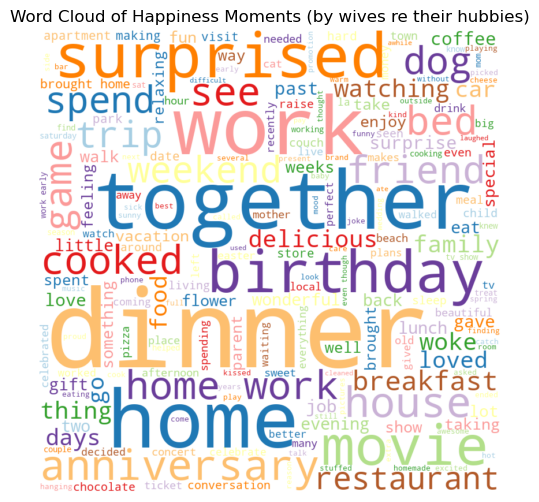

In [18]:
# Join the words back into a single string
text = ' '.join(words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='Paired').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Happiness Moments (by wives re their hubbies)')
plt.axis('off')
plt.show()

The bar chart and word cloud above offer insights into what wives appreciate and find happiness in, based on their conversations about their husbands. 

The most frequent word that appears is "**dinner**," suggesting that **shared meals** are highly valued. This could mean that wives appreciate the **quality time** spent with their husbands during meals, whether it's a casual dinner at home or a more elaborate meal out. The act of dining together can be a moment of connection and enjoyment.

Other frequent words like **"surprise," "anniversary," "brought," "love,"** and **"breakfast"** indicate that wives cherish **special occasions and unexpected gestures**. Celebrating anniversaries and the joy of receiving surprises point to a desire for recognition and the importance of marking milestones. The mention of "breakfast" alongside "dinner" shows an appreciation for efforts made by husbands at various times of the day.

Words such as "weekend," "trip," "restaurant," "beach," and "vacation" highlight the importance of **shared experiences and leisure activities**. Getting away from the routine, whether for a short weekend trip or a longer vacation, and enjoying leisure time together at places like restaurants or the beach are significant for happiness.

The word "work" also appears frequently, which might suggest that wives value the balance their husbands strike between their professional and personal lives, or it could indicate that they appreciate conversations about each other's work life as a form of mutual support.

The word cloud reinforces these findings with additional context, where words like "home," "friend," "family," "love," "enjoy," "watching," and "game" are prominent. It's clear that social activities, familial connections, and shared hobbies are also part of what brings joy in these relationships.

In [19]:
# Extract sentences containing the word "husband"
sentences_containing_husband = []
for cleaned_hm in wife_df['cleaned_hm']:
    sentences = re.split(r'[.!?]', cleaned_hm)
    for sentence in sentences:
        if 'husband' in sentence.lower():
            sentences_containing_husband.append(sentence.strip())

# Randomly select 5 sentences
selected_sentences = random.sample(sentences_containing_husband, k=5)

# Print the selected sentences
for idx, sentence in enumerate(selected_sentences, start=1):
    print(f"Sentence {idx}: {sentence}")

Sentence 1: I went hiking with my husband to our favorite park
Sentence 2: My husband surprised me with the news of a great new job
Sentence 3: Going out to dinner with my husband and having great conversation with him made me happy
Sentence 4: I spent time with my husband watching one of our favorite shows on Netflix
Sentence 5: Last night we had an Optometrist Apt for my husband
